In [1]:
import sys
sys.path.append('..')

In [2]:
from core.logger import load_json
opt = load_json('../config/splitting_hagen_classifier.json')

In [3]:
from data.time_predictor_dataset import TimePredictorDataset
from data.split_dataset import DataLocation


def get_datasets(opt, tiled_pred=False):
    patch_size = opt['datasets']['patch_size']
    target_channel_idx = opt['datasets'].get('target_channel_idx', None)
    upper_clip = opt['datasets'].get('upper_clip', None)
    max_qval = opt['datasets']['max_qval']
    channel_weights = opt['datasets'].get('channel_weights', None)

    data_type = opt['datasets']['train']['name']  
    uncorrelated_channels = opt['datasets']['train']['uncorrelated_channels']
    assert data_type in ['cifar10', 'Hagen']
    if data_type == 'Hagen':
        train_data_location = DataLocation(channelwise_fpath=(opt['datasets']['train']['datapath']['ch0'],
                                                        opt['datasets']['train']['datapath']['ch1']))
        val_data_location = DataLocation(channelwise_fpath=(opt['datasets']['val']['datapath']['ch0'],
                                                        opt['datasets']['val']['datapath']['ch1']))
    elif data_type == 'cifar10':
        train_data_location = DataLocation(directory=(opt['datasets']['train']['datapath']))
        val_data_location = DataLocation(directory=(opt['datasets']['val']['datapath']))
    
    
    train_set = TimePredictorDataset(data_type, train_data_location, patch_size, 
                             target_channel_idx=target_channel_idx, 
                                max_qval=max_qval, upper_clip=upper_clip,
                                uncorrelated_channels=uncorrelated_channels,
                                channel_weights=channel_weights,
                             normalization_dict=None, enable_transforms=True,random_patching=True)

    if not tiled_pred:
        class_obj = TimePredictorDataset 
    else:
        data_shape = (10, 2048, 2048)
        tile_manager = get_tile_manager(data_shape, (1, patch_size//2, patch_size//2), (1, patch_size, patch_size))
        class_obj = get_tiling_dataset(TimePredictorDataset, tile_manager)

    val_set = class_obj(data_type, val_data_location, patch_size, target_channel_idx=target_channel_idx,
                           normalization_dict=train_set.get_normalization_dict(),
                           max_qval=max_qval,
                            upper_clip=upper_clip,
                            channel_weights=channel_weights,
                           enable_transforms=False,
                                                     random_patching=False)
    return train_set, val_set



INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.17 (you have 1.4.7). Upgrade using: pip install --upgrade albumentations


In [4]:
train_set, val_set = get_datasets(opt, tiled_pred=False)

HARDCODED upperclip to 1993. Disable it if not needed !!!
Computing mean and std for normalization
[TimePredictorDataset] Data: 80x2x(2048, 2048) Patch:512 Random:1 Aug:True Q:0.995 UpperClip:0Uncor:False ChW:[1.0, 1.0]


100%|██████████| 21/21 [02:56<00:00,  8.40s/it]


HARDCODED upperclip to 1993. Disable it if not needed !!!
[TimePredictorDataset] Data: 10x2x(2048, 2048) Patch:512 Random:0 Aug:False Q:0.995 UpperClip:0Uncor:False ChW:[1.0, 1.0]


100%|██████████| 21/21 [00:23<00:00,  1.13s/it]


In [9]:
from model.ddpm_modules.time_predictor import TimePredictor
model_opt = opt['model']
model = TimePredictor(
        in_channel=model_opt['unet']['in_channel'],
        out_channel=model_opt['unet']['out_channel'],
        norm_groups=model_opt['unet']['norm_groups'],
        inner_channel=model_opt['unet']['inner_channel'],
        channel_mults=model_opt['unet']['channel_multiplier'],
        attn_res=model_opt['unet']['attn_res'],
        res_blocks=model_opt['unet']['res_blocks'],
        dropout=model_opt['unet']['dropout'],
        image_size=opt['datasets']['patch_size'],
        )
model = model.cuda()


In [10]:
# create data loaders.
from torch.utils.data import DataLoader
train_loader = DataLoader(train_set, batch_size=opt['datasets']['train']['batch_size'], shuffle=True, num_workers=opt['datasets']['train']['num_workers'])
val_loader = DataLoader(val_set, batch_size=opt['datasets']['train']['batch_size'], shuffle=False, num_workers=opt['datasets']['train']['num_workers'])

# create optimizer.
import torch
from torch.optim import Adam
optimizer = Adam(model.parameters(), lr=opt['train']['optimizer']['lr'])

# create loss function.
loss_fn = torch.nn.MSELoss()



In [11]:
# start training with pytorch.
from tqdm import tqdm
import numpy as np

# tqdm bar with loss 
bar = tqdm(enumerate(train_loader))
loss_arr = []
num_epochs = 10
for epoch in range(num_epochs):
    for i, (x, y) in bar:
        model.train()
        optimizer.zero_grad()
        x = x.cuda()
        y = y.cuda()
        y_pred = model(x)
        loss = loss_fn(y_pred, y.type(torch.float32))
        loss.backward()
        loss_arr.append(loss.item())
        bar.set_description(f'loss {np.mean(loss_arr[-20:])}')
        optimizer.step()

model.eval()
# for i, (x, y) in enumerate(val_loader):
#     y_pred = model(x)
#     loss = loss_fn(y_pred, y)
#     print(f'epoch {epoch}, val iter {i}, loss {loss.item()}')
# torch.save(model.state_dict(), f'./model_{epoch}.pth')


0it [00:00, ?it/s]/localscratch/miniforge3/envs/usplit_vdi/lib/python3.9/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
loss 0.07421324979513884: : 33it [00:05,  5.73it/s]

<Axes: >

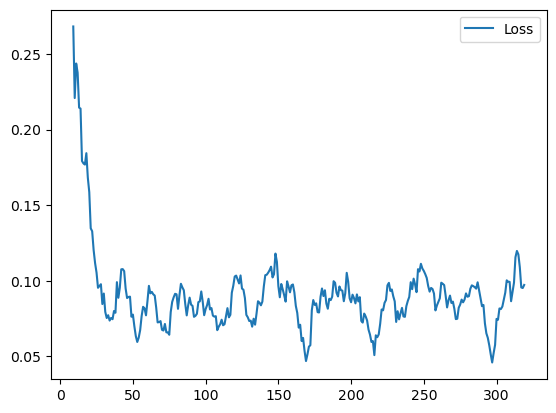

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
pd.Series(loss_arr).to_frame('Loss').rolling(10).mean().plot()